## Michelle Kouba
## Time Series Analysis with a SARIMA


In [ ]:
# Importing libraries
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import calendar
import datetime
from datetime import date
from pandas import DataFrame
from pandas import Grouper
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
import warnings
warnings.filterwarnings('ignore')

### Exploratory Data Analysis

In [ ]:
# Opening retail sales datafile and inspecting it
df = pd.read_csv('us_retail_sales.csv')
df.head()

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,1992,146925,147223,146805,148032,149010,149800,150761.0,151067.0,152588.0,153521.0,153583.0,155614.0
1,1993,157555,156266,154752,158979,160605,160127,162816.0,162506.0,163258.0,164685.0,166594.0,168161.0
2,1994,167518,169649,172766,173106,172329,174241,174781.0,177295.0,178787.0,180561.0,180703.0,181524.0
3,1995,182413,179488,181013,181686,183536,186081,185431.0,186806.0,187366.0,186565.0,189055.0,190774.0
4,1996,189135,192266,194029,194744,196205,196136,196187.0,196218.0,198859.0,200509.0,200174.0,201284.0


In [ ]:
# Renaming column names to something I'd use
df = df.rename(columns={'YEAR': 'Year'})

In [ ]:
# Data is in a matrix and not a vector so I'll transform the data.
df = pd.melt(df, id_vars =['Year'], var_name = 'Month', value_name = 'Sales')

In [ ]:
# Combining Month and Year to one column
# Making month numeric
df.Month.replace(('JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC',), (1,2,3,4,5,6,7,8,9,10,11,12), inplace=True)
# Converting Month to an integer
df['Month'] = pd.to_numeric(df['Month'])
df = df.sort_values(by =['Year', 'Month'])
#Combining Month and Year into a Date
df['Date']=pd.to_datetime(df[['Year', 'Month']].assign(day=1))
#Dropping Month and Year from the data
df = df.drop(['Year', 'Month'],axis=1)

Text(0, 0.5, 'Sales')

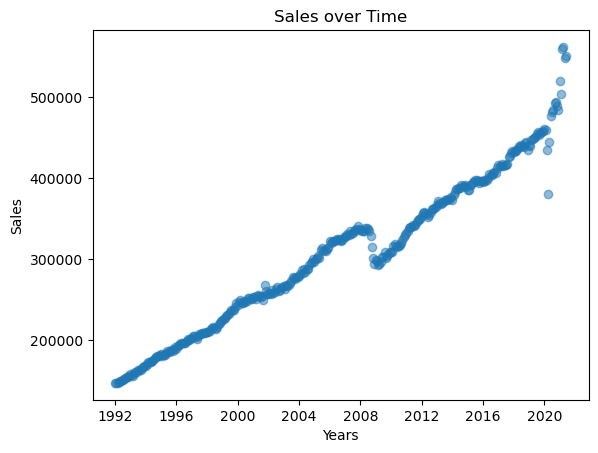

In [ ]:
plt.plot_date(df.Date, df.Sales, alpha=0.5)
plt.title('Sales over Time')
plt.xlabel('Years')
plt.ylabel('Sales')

The data appears to have a large drop around 2008 but appears to consistently climb in a mostly regular pattern.   The upswing in the data in the last year or so will make it harder to correctly predict future sales.  Despite the growth reduction around 2009-2010, the data shows a clear and steady slope that is similar before and after 2009-2009.  There does appear to be small and regular seasonal fluctations.  This increasing variability towards the end of the data signals a rise in heteroscedasticity, or variance of residuals which fitted to a line.   This needs to be accounted for in the model.

In [ ]:
# Splitting the data into a training and test set
# Specifying split date
split_date ='2020-06-01'
#Splitting data by date
df_training = df.loc[df['Date'] <= split_date]
df_test = df.loc[df['Date'] > split_date]
# Getting rid of the blank data of the last year
df_test = df_test.dropna()
# Creating X and Y variables
train = df_training['Sales']
test = df_test['Sales']

## SARIMA

In [ ]:
# Creating a function that finds the best parameters for the SARIMA
def optimize_SARIMA(parameters_list, d, D, s, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """

    results = []

    for param in tqdm_notebook(parameters_list):
        try:
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue

        aic = model.aic
        results.append([param, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better so the first number is the best fit!
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [ ]:
# Generating a list of all possible parameter combinations (Guessing seasonal will be 12 months)
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 12
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print("The total number of possible parameter combinations is", len(parameters_list))

The total number of possible parameter combinations is 256


In [ ]:
# Using a SARIMA due to the small seasonal/yearly fluctations.
result_df = optimize_SARIMA(parameters_list, 1, 1, 4, train)
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",AIC
0,"(2, 2, 0, 0)",6835.549208
1,"(2, 2, 0, 1)",6837.449685
2,"(2, 2, 1, 0)",6837.453378
3,"(2, 3, 0, 0)",6837.535944
4,"(3, 2, 0, 0)",6837.692370
...,...,...
251,"(1, 0, 1, 0)",6875.334109
252,"(0, 1, 1, 0)",6875.351248
253,"(0, 0, 0, 0)",6875.830102
254,"(0, 1, 0, 0)",6877.760485


In [ ]:
print('The minimum AIC in these 256 parameter settings is', min(result_df.AIC))

The minimum AIC in these 256 parameter settings is 6835.549208363987


Using this grid search to search all possible 256 combinations of likely parameters, we see that the minimum AIC (Akaike's Information Criterion) is 16.0.  From the results_df above we can see then that the best model is SARIMA(0,1,2)(2,2,0,0).  I gleaned the (0,1,2) from the order, and the (2,2,0,0) from the lowest AIC with the 2's denoting the p, q, P(auto), and the Q().

In [ ]:
# Defining the best model based on the parameters gleaned from the lowest AIC from the grid search above.
best_model = SARIMAX(train, order=(0, 1, 2), seasonal_order=(2, 2, 0, 3)).fit(dis=-1)
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                  342
Model:             SARIMAX(0, 1, 2)x(2, 2, [], 3)   Log Likelihood               -3494.447
Date:                            Sun, 07 May 2023   AIC                           6998.893
Time:                                    19:54:04   BIC                           7017.964
Sample:                                         0   HQIC                          7006.496
                                            - 342                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1677      0.024     -6.961      0.000      -0.215      -0.120
ma.L2         -0.3609      0.027   

I can see that the best model has both seasonal and non-seasonal moving average processes so the SARIMA was a good fit (when compared to the ARIMA).  All the coefficients are statistically significant (below 0.05 P>z), so this model seems to be a good fit.  the JB statistic is also statistically significant (p<0.01).  To confirm this is a model of good fit, I'll graph the residuals.

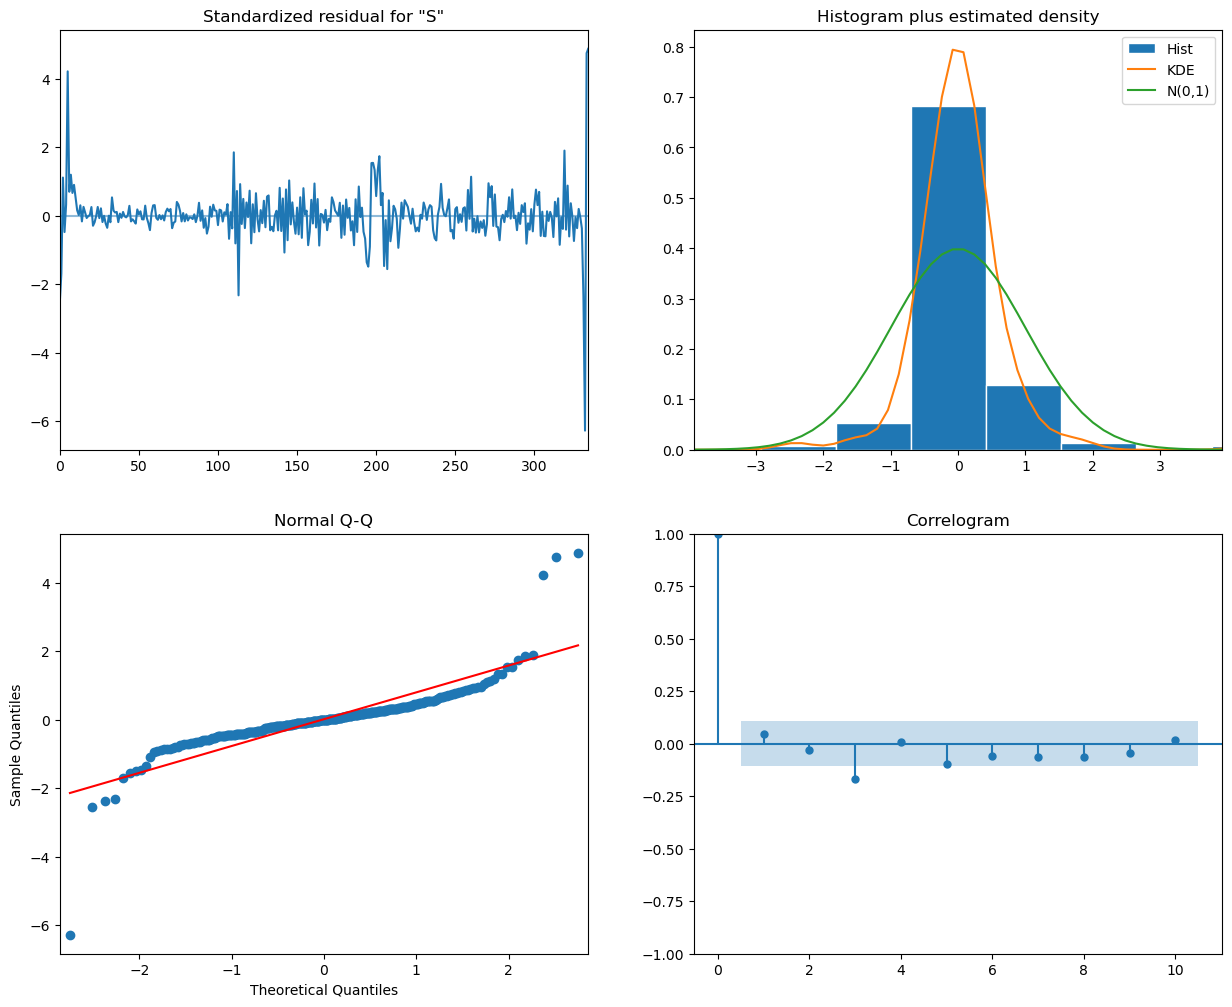

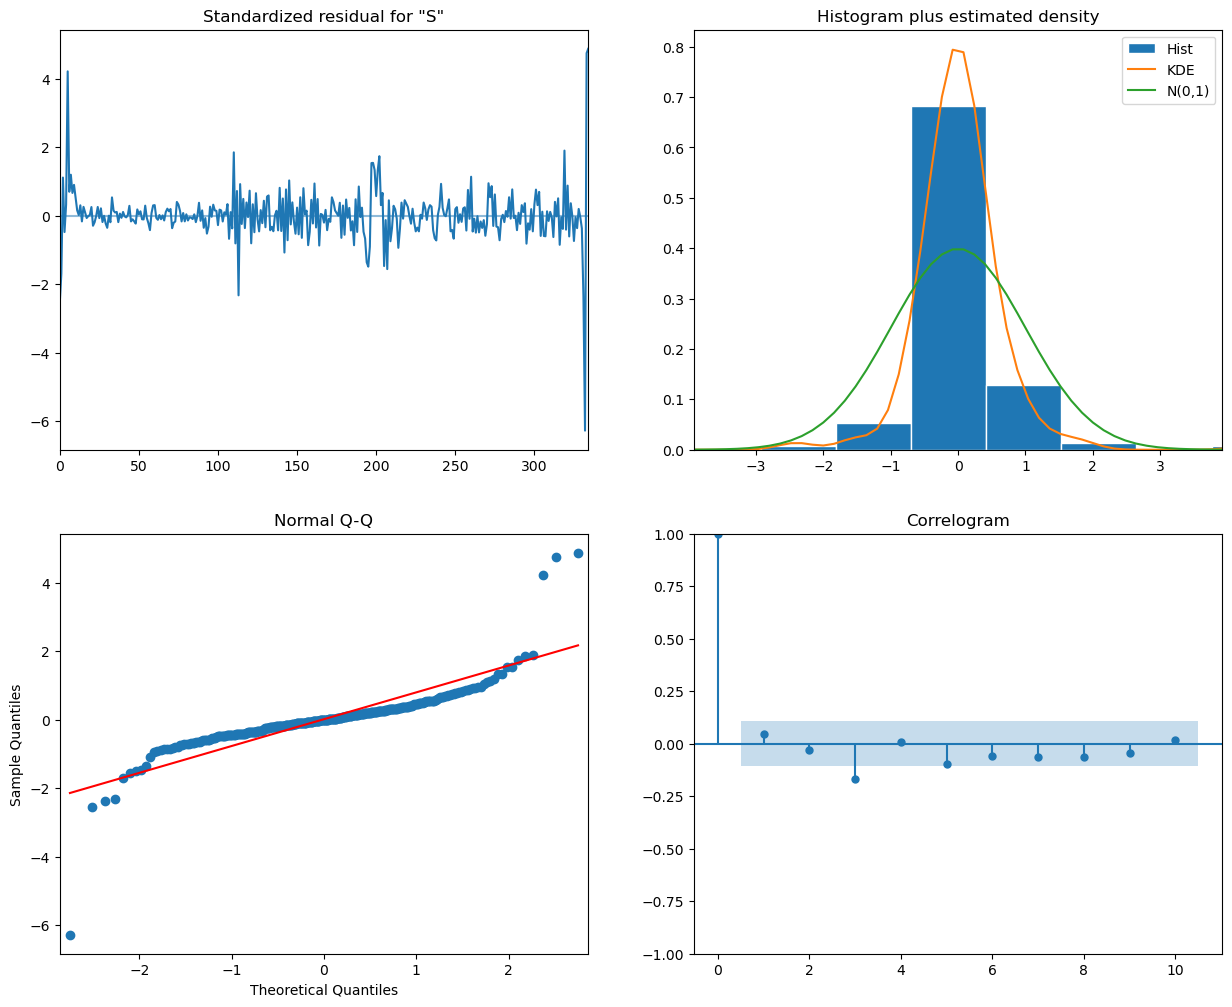

In [ ]:
# Graphing the residuals and other diagnostics.
best_model.plot_diagnostics(figsize=(15,12))

The Normal Q-Q plot deviates from the red line a little more than I would prefer, but overall it's a really good fit.  This could be due to that major decrease in the data around 2008?  The correlogram looks good showing no autocorrelation of the residuals so it's just randomness or white noise.  The standardized residuals show a repetition pattern, but I know the low deviation from 0 is a good sign.  The histogram is mostly normally distributed so this is a good sign of fit as well.

In [ ]:
# Using the training model to predict the forecasted next 12 months
# Appending files back together
predictions = best_model.predict()
df['Predictions'] = predictions

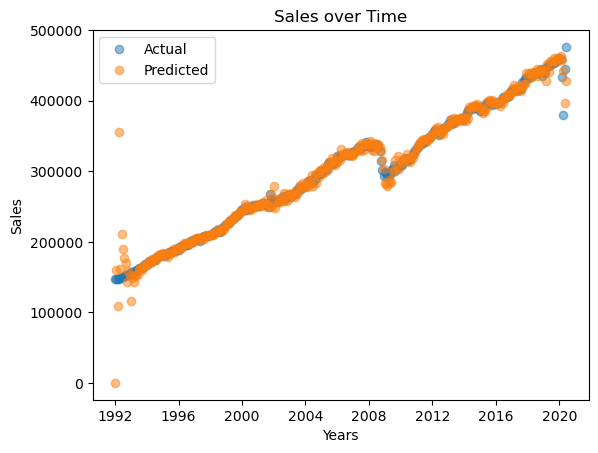

In [ ]:
# Plotting the actual versus predicted forecasted data for sales
plt.plot_date(df.Date, df.Sales, alpha=0.5, label = "Actual")
plt.plot_date(df.Date, df.Predictions, alpha=0.5, label = "Predicted")
plt.title('Sales over Time')
plt.xlabel('Years')
plt.ylabel('Sales')
plt.legend()

In [ ]:
# Looking at the RMSE of the data just for the predicted last year of data.
# Calculating the RMSE on the model.
from sklearn.metrics import mean_squared_error
#setting squared=False to get the RMSE
print('The RMSE of the this SARIMA model is', mean_squared_error(df.Sales, df.Predictions, squared=False))

The RMSE of the this SARIMA model is 16411.667214858724


Given that the sales are in the 100,000 to 500,000 range, I think a RMSE of 16411 is indicative of a good predictive fit.  The model had a little trouble predicting well in the beginning and the end of the data but some of that is due to the variability in the newest sales figures.  The plot above shows a very good fit overall and all other metrics show it to be a good fit as well.  The coefficients from the model of best fit summary (SARIMAX results) are all statistically significant.  